In [1]:
#papermill_description=IMPORT_DEPENDENCIES
import torch
from torch import nn, Tensor, tensor
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import json
import os
from typing import List, Dict, Any, Tuple
from scipy.stats import pearsonr

## 0. Load necessities and Dataset Statistics Overview

In [2]:
#papermill_description=LOAD_NECESSITIES
#load inference results
# with open('./inference_results/mixed_alpha_0.5_t1_0.16_t2_0.16.pkl', 'rb') as f:
TRANSPOSE=True
print('loading inference results')
with open('./inference_results/mixed_alpha_0.5_t1_0.16_t2_0.16_label_correct_only.pkl' if not TRANSPOSE else './inference_results/mixed_alpha_0.5_t1_0.133_t2_0.133_transpose_labelonly.pkl', 'rb') as f:
    inference_result = pkl.load(f)
with open('./inference_results/sample_labelmap.json', 'r') as f:
    print('loading sample labelmap')
    labelmap = json.load(f)
kde_pretrained_prefix = './probability_distributions'
with open(f'{kde_pretrained_prefix}/neg_arc_conditional_1.pkl', 'rb') as f_neg_postcond, \
    open(f'{kde_pretrained_prefix}/label_conditional_1.pkl', 'rb') as f_label_postcond, \
    open(f'{kde_pretrained_prefix}/joint_label_1.pkl', 'rb') as f_joint_label, \
    open(f'{kde_pretrained_prefix}/joint_neg_1.pkl', 'rb') as f_joint_neg, \
    open(f'{kde_pretrained_prefix}/x_1.pkl', 'rb') as f_x:
    print('loading KDE results')
    neg_postcond = pkl.load(f_neg_postcond) # f(L=0|a)
    label_postcond = pkl.load(f_label_postcond) # f(l|a)
    joint_label = pkl.load(f_joint_label) # f(l,a)
    joint_neg = pkl.load(f_joint_neg) # f(L=0,a)
    x = pkl.load(f_x)
with open(f'{kde_pretrained_prefix}/mi_1.json') as f:
    print('loading mutual information')
    mi = json.load(f) # f(l)

loading inference results
loading sample labelmap
loading KDE results
loading mutual information


In [62]:
"""
1	Influential	_	JJ	JJ	_	2	amod	_	_
"""
class Sentence:
    def __init__(self, tokens: List[str], head_indices: List[int], labels: List[str]):
        self.tokens = tokens
        self.head_indices = head_indices # starting from 0
        head_set = set(self.head_indices)
        self.labels = labels
        self.heights = [0] * len(self.tokens)
        # calculate the height of each token, iterately get head_indices until it is `-1`
        for idx in range(len(self.tokens)):
            if idx not in head_set:
                self.heights[idx] = 0
            head_idx = self.head_indices[idx]
            height = 1
            while head_idx != -1:
                if height > self.heights[head_idx]:
                    self.heights[head_idx] = height
                height += 1
                head_idx = self.head_indices[head_idx]
        # for idx in range(len(self.tokens)):
        #     height = 0
        #     dependant_idx = self.dependant_indices[idx]
        #     while dependant_idx != -1:
        #         height += 1
        #         dependant_idx = self.dependant_indices[dependant_idx]
        #     self.heights[idx] = height
            
        # for idx in range(len(self.tokens)):
        #     height = 0
        #     head_idx = self.head_indices[idx]
        #     while head_idx != -1:
        #         height += 1
        #         head_idx = self.head_indices[head_idx]
        #     self.heights[idx] = height
    
    def __len__(self):
        return len(self.tokens)
    
    def find_label(self, label_name: str):
        for each in self.labels:
            if each == label_name:
                return True
    
    def __repr__(self):
        token_string, label_string, head_string, height_string = '', '', '', ''
        # assign different random colors for each token
        colors = [np.random.rand(3,) for _ in range(len(self.tokens))]

        for token, head_idx, label, height in zip(self.tokens, self.head_indices, self.labels, self.heights):
            head_token = self.tokens[head_idx]
            max_length = max(len(token), len(head_token), len(label))
            token_string += f'{token:<{max_length}} '
            head_string += f'{head_token:<{max_length}} '
            label_string += f'{label:<{max_length}} '
            height_string += f'{height:<{max_length}} '

        return  '/'+ '=' * (6 + len(token_string)) + '\\\n' + \
                f'Tokens: {token_string}\nLabels: {label_string}\nHeads:  {head_string}\nHeights:{height_string}'

words = set()
sentences = []
label2dist = defaultdict(list)
# label2direction: [0] stands for pointing to left, [1] stands for pointing to right
label2direction = defaultdict(lambda: [0, 0])
with open('./data/train.conllu', 'r') as f:
    this_sentence = []
    for line in f.read().split('\n'):
        line = line.strip()
        if line:
            word_idx, word, _, _, _, _, head_idx, label, _, _ = line.split('\t')
            word_idx, head_idx = int(word_idx), int(head_idx)
            this_sentence.append((word, head_idx - 1, label))
            label2dist[label].append(abs(word_idx - head_idx))
            if word_idx < head_idx:
                label2direction[label][1] += 1
            else:
                label2direction[label][0] += 1
        
        else:
            if this_sentence:
                sentences.append(Sentence(*zip(*this_sentence)))
            this_sentence = []

label2direction_name = {label: 'left' if direction[0] > direction[1] else 'right' for label, direction in label2direction.items()}

label2avgdist = {label: sum(dists) / len(dists) for label, dists in label2dist.items()}
label2height = defaultdict(list)
for each in sentences:
    for idx, height in enumerate(each.heights):
        try:
            label2height[each.labels[idx]].append(height)
        except ZeroDivisionError:
            pass

label2avgheight = {label: sum(heights) / len(heights) for label, heights in label2height.items()}

In [43]:
label2avgheight['det'], label2avgheight['nn'], label2avgheight['nsubj'], label2avgheight['root']

(0.0, 0.013503212457802461, 0.9592943560402885, 1.012427194215706)

## 1. Result analysis

In [4]:
labelmap_invert = {v: k for k, v in labelmap.items()}
label_corrects, label_totals = inference_result['label_corrects'], inference_result['label_totals']
label_corrects_filtered, label_totals_filtered, label_accs_filtered = {}, {}, {}
for label_idx, label_total in label_totals.items():
    if label_total != 0:
        label_corrects_filtered[labelmap_invert[label_idx]] = label_corrects[label_idx]
        label_totals_filtered[labelmap_invert[label_idx]] = label_total
        label_accs_filtered[labelmap_invert[label_idx]] = label_corrects[label_idx] / label_total

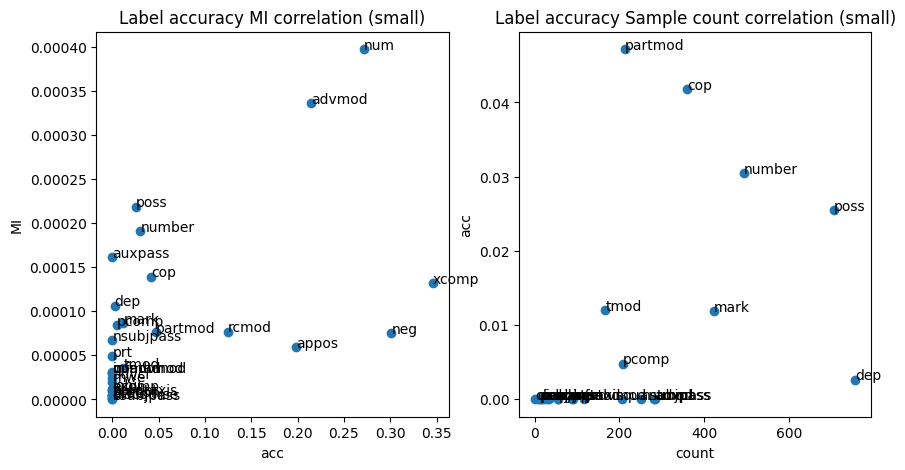

In [77]:
def scatter_with_label(ax: plt.Axes, xs, ys, labels, title: str, xlabel: str, ylabel: str, 
    text_min_x: float = -114514, text_min_y: float = -114514, max_x: float = 1145141919810, max_y: float = 1145141919810):
    x_mask = np.array(xs) < max_x
    y_mask = np.array(ys) < max_y
    mask = x_mask & y_mask
    xs = np.array(xs)[mask]
    ys = np.array(ys)[mask]
    labels = [each for idx, each in enumerate(labels) if mask[idx]] 
    ax.scatter(xs, ys)
    for x, y, label in zip(xs, ys, labels):
        if x >= text_min_x and y >= text_min_y:
            ax.text(x, y, label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

avg_mis = [np.mean(each) for each in mi['binary_label_mi']]
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
scatter_with_label(ax, list(label_accs_filtered.values())[:-1], avg_mis[:-1], list(label_accs_filtered.keys())[:-1], 'Label accuracy MI correlation', 'acc', 'MI', text_min_x=0.38)
ax = plt.subplot(1, 2, 2)
scatter_with_label(ax, list(label_totals_filtered.values())[:-1], list(label_accs_filtered.values())[:-1], list(label_totals_filtered.keys())[:-1], 'Label accuracy Sample count correlation', 'count', 'acc', text_min_y=0.1)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
scatter_with_label(ax, list(label_accs_filtered.values())[:-1], avg_mis[:-1], list(label_accs_filtered.keys())[:-1], 'Label accuracy MI correlation (small)', 'acc', 'MI', max_x=0.38)
ax = plt.subplot(1, 2, 2)
scatter_with_label(ax, list(label_totals_filtered.values())[:-1], list(label_accs_filtered.values())[:-1], list(label_totals_filtered.keys())[:-1], 'Label accuracy Sample count correlation (small)', 'count', 'acc', max_y=0.1)

In [60]:
#papermill_description=FILTER_OUT_HIGH_ACC_LABELS
# label2direction_name['pobj'], label2direction_name['nsubj'], label2direction_name['det'], label2direction_name['prep'], label2direction_name['nn']
high_accuracy_labels = [each[0] for each in sorted(label_accs_filtered.items(), key=lambda x: x[1], reverse=True)[:20]]
high_accuracy_direction_indicators = ''
high_accuracy_directions = {'left': 0, 'right': 0}
for each in high_accuracy_labels:
    high_accuracy_directions[label2direction_name[each]] += 1
    if label2direction_name[each] == 'left':
        high_accuracy_direction_indicators += '⬅️'
    else:
        high_accuracy_direction_indicators += '➡️'

print(high_accuracy_directions)
print(high_accuracy_direction_indicators)

{'left': 12, 'right': 8}
⬅️⬅️⬅️⬅️➡️➡️⬅️➡️⬅️⬅️➡️⬅️⬅️➡️⬅️➡️➡️➡️⬅️⬅️


## 2. MI Analysis

In [6]:
from explaination import estimate_kde_torch, estimate_mi, integral_torch_cuda

binary_label_mi_flatten = Tensor([mi_item for each in mi['binary_label_mi'][:-1] for mi_item in each])
binary_label_mi_pos_flatten = Tensor([mi_item for each in mi['pos_binary_label_mi'] for mi_item in each])
x_mi_interval = binary_label_mi_flatten.max().item() / 1000
x_mi_pos_interval = binary_label_mi_pos_flatten.max().item() / 1000
x_mi = torch.arange(0, binary_label_mi_flatten.max().item() + x_mi_interval, x_mi_interval)
x_mi_pos = torch.arange(0, binary_label_mi_pos_flatten.max().item() + x_mi_pos_interval, x_mi_pos_interval)
# treat x_mi, x_mi_pos as interval bins and put the samples from binary_label_mi_flatten, binary_label_mi_pos_flatten into the bins
binary_label_mi_bin_sample_counts = torch.histc(binary_label_mi_flatten, bins=x_mi)
# print(binary_label_mi_flatten.max(), binary_label_mi_pos_flatten.max())
# binary_label_mi_flatten_density = estimate_kde_torch(
#     x_mi, binary_label_mi_flatten)
# binary_label_mi_pos_flatten_density = estimate_kde_torch(
#     x_mi_pos, binary_label_mi_pos_flatten)

# print(integral_torch_cuda(x_mi, binary_label_mi_flatten_density * torch.log2(binary_label_mi_flatten_density)))
# print(integral_torch_cuda(x_mi_pos, binary_label_mi_pos_flatten_density * torch.log2(binary_label_mi_pos_flatten_density)))

using modified version of Apple OpenELM


TypeError: histc(): argument 'bins' must be int, not Tensor

In [8]:
# compare across labels
binary_label_mi_pos = mi['pos_binary_label_mi']
head_hit_cnts = defaultdict(int)
for each in binary_label_mi_pos:
    for head_idx in np.argsort(each)[::-1][:10]:
        head_hit_cnts[head_idx] += 1

print(sorted(head_hit_cnts.values(), reverse=True))
print(list(head_hit_cnts.values()).count(1))
print(len(head_hit_cnts))
print([each for each in head_hit_cnts.items() if each[1] >= 6])

[7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
183
283
[(59, 6), (139, 7), (96, 6), (365, 6), (580, 6)]


['root', 'punct', 'pobj', 'prep', 'det', 'nsubj', 'dobj', 'amod', 'conj', 'ccomp']
average_heights = [2.8269668303197224, 0.0, 1.7285240260538282, 0.0, 0.1412180344377858, 1.1463138446868109, 2.157013734599071, 1.817669095549792, 5.601626832697328, 4.497119554663732]
weighted_layer_idx_sums = [13.799125382977177, 14.589459154185104, 14.608855498711955, 13.875609856053318, 15.357002616806804, 14.768687112142702, 15.781826220067888, 14.506474281205454, 16.68767379598365, 16.758930897052203]
PearsonRResult(statistic=0.6929826645524904, pvalue=0.02630198662421642)


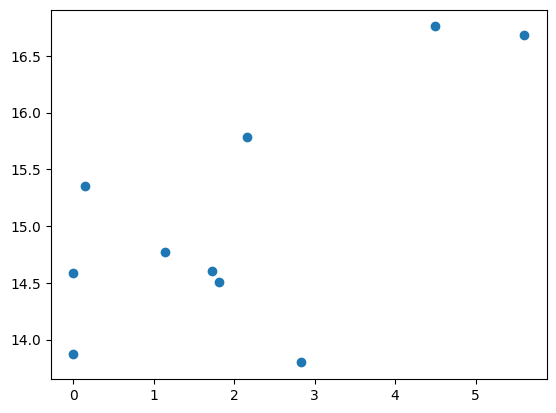

In [72]:
def get_split_points(lst: List[float]):
    """the list in unsorted. get the half cumsum split point"""
    totalsum = sum(lst)
    cumsum = 0
    first_quantile, second_quantile, third_quantile = -1, -1, -1
    for idx, each in enumerate(lst):
        cumsum += each
        if cumsum >= totalsum * 0.25 and first_quantile == -1:
            first_quantile = idx
        if cumsum >= totalsum * 0.5 and second_quantile == -1:
            second_quantile = idx
        if cumsum >= totalsum * 0.75 and third_quantile == -1:
            third_quantile = idx
    
    return first_quantile, second_quantile, third_quantile
        
high_accuracy_labels = [each[0] for each in sorted(label_accs_filtered.items(), key=lambda x: x[1], reverse=True)[:10]]

print(high_accuracy_labels)

# label_avgheight_halfsplit = []
# for label_idx, each in enumerate(binary_label_mi_pos):
#     label_name = list(label_accs_filtered.keys())[label_idx]
#     if label_name in high_accuracy_labels:
#         label_avgheight_halfsplit.append((label_name, label2avgheight[label_name], get_split_points(each) ))
# # calculate pearson correlation between average height and first quantile
# print(pearsonr([each[1] for each in label_avgheight_halfsplit], [each[2][0] for each in label_avgheight_halfsplit]))

average_heights, weighted_layer_idx_sums  = [], []
for label_idx, each in enumerate(binary_label_mi_pos):
    label_name = list(label_accs_filtered.keys())[label_idx]
    if label_name in high_accuracy_labels:
        average_heights.append(label2avgheight[label_name])
        weighted_layer_idx_sums.append(sum([(idx // 32 + 1) * val for idx, val in enumerate(each)]) / sum(each))
# calculate pearson correlation between average height and first quantile
print(f'{average_heights = }')
print(f'{weighted_layer_idx_sums = }')
print(pearsonr(average_heights, weighted_layer_idx_sums))
plt.scatter(average_heights, weighted_layer_idx_sums)

In [47]:
3 // 32

0

## 3. Distribution Analysis

In [26]:
label_names = list(label_totals_filtered.keys())
labels_sorted_by_mi = [label_names[each[0]] for each in sorted([*enumerate(avg_mis)], key=lambda x: x[1], reverse=True)]
print(labels_sorted_by_mi[:10])

['<s>', 'root', 'pobj', 'prep', 'det', 'amod', 'nn', 'punct', 'nsubj', 'dobj']


In [153]:
print(len(label_names), len(mi['binary_label_mi']))

46 46
{'prep': 0.8913560666137986, 'det': 0.8898533373241544, 'nn': 0.4925925925925926, 'num': 0.27138914443422263, 'pobj': 0.9281517094017094, 'punct': 0.9355316000845487, 'poss': 0.025495750708215296, 'possessive': 0.45622119815668205, 'amod': 0.7032700847799758, 'nsubj': 0.8268688293370945, 'appos': 0.19858156028368795, 'dobj': 0.7246913580246913, 'dep': 0.0026455026455026454, 'cc': 0.43156843156843155, 'conj': 0.6842629482071713, 'nsubjpass': 0.0, 'partmod': 0.04716981132075472, 'auxpass': 0.0, 'advmod': 0.21479713603818615, 'root': 1.0, 'ccomp': 0.6732142857142858, 'aux': 0.40707964601769914, 'cop': 0.04178272980501393, 'xcomp': 0.3456221198156682, 'quantmod': 0.0, 'tmod': 0.011976047904191617, 'neg': 0.30120481927710846, 'infmod': 0.0, 'rcmod': 0.1245674740484429, 'pcomp': 0.004784688995215311, 'mark': 0.011848341232227487, 'advcl': 0.0, 'predet': 0.0, 'csubj': 0.0, 'mwe': 0.0, 'parataxis': 0.0, 'npadvmod': 0.0, 'number': 0.030425963488843813, 'acomp': 0.0, 'prt': 0.0, 'iobj': 0.

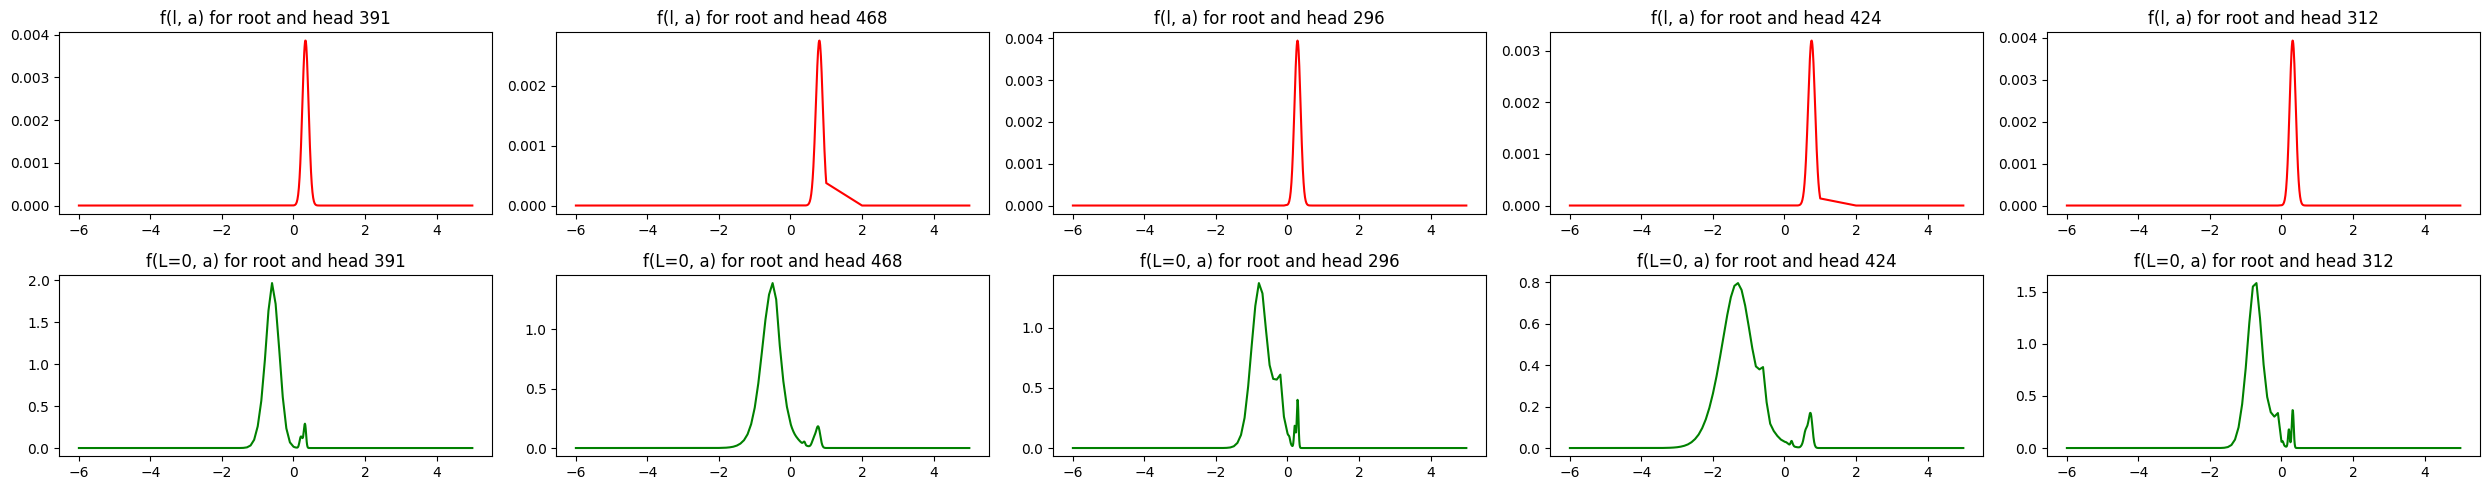

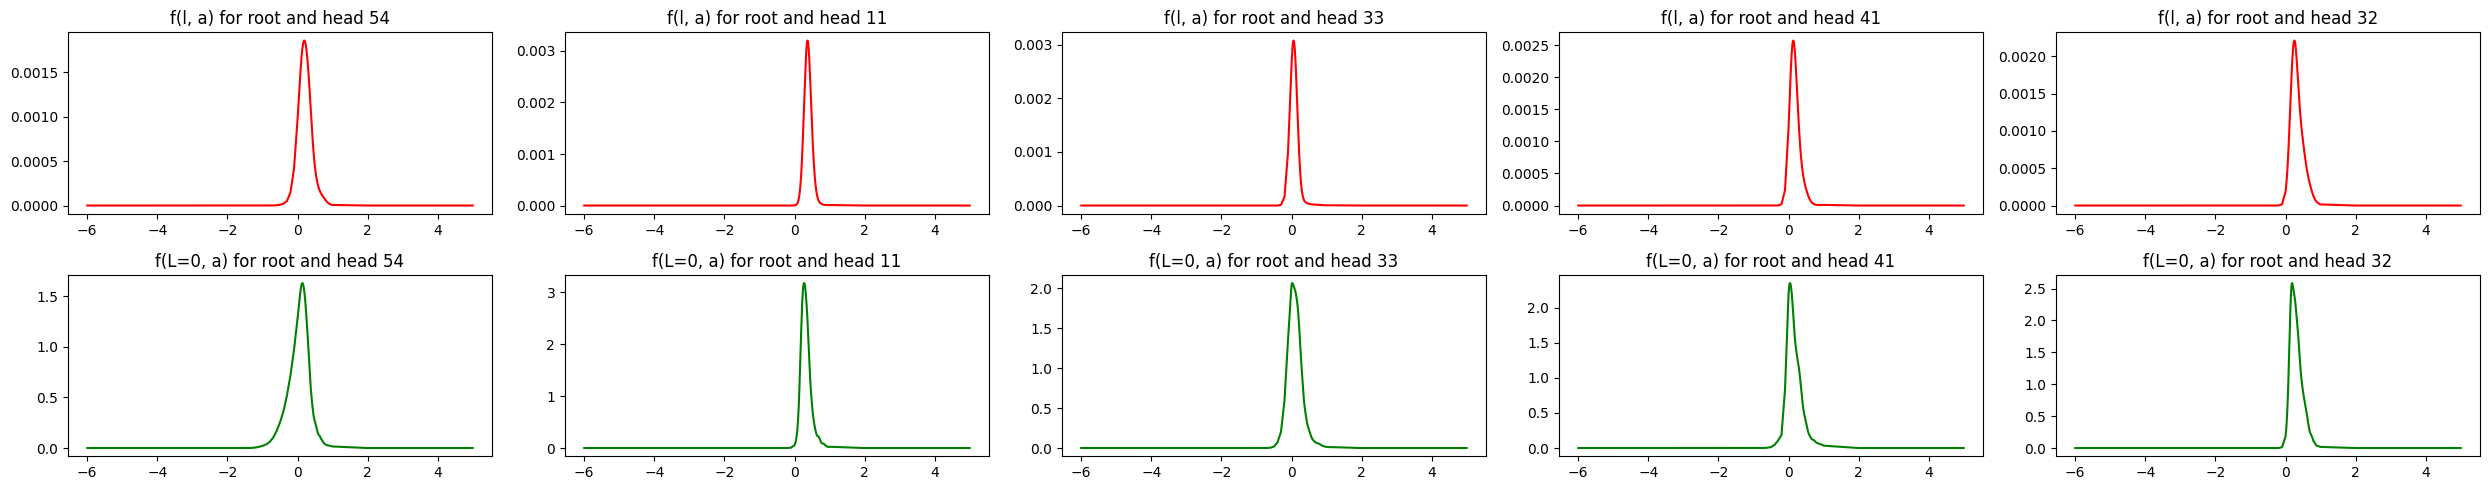

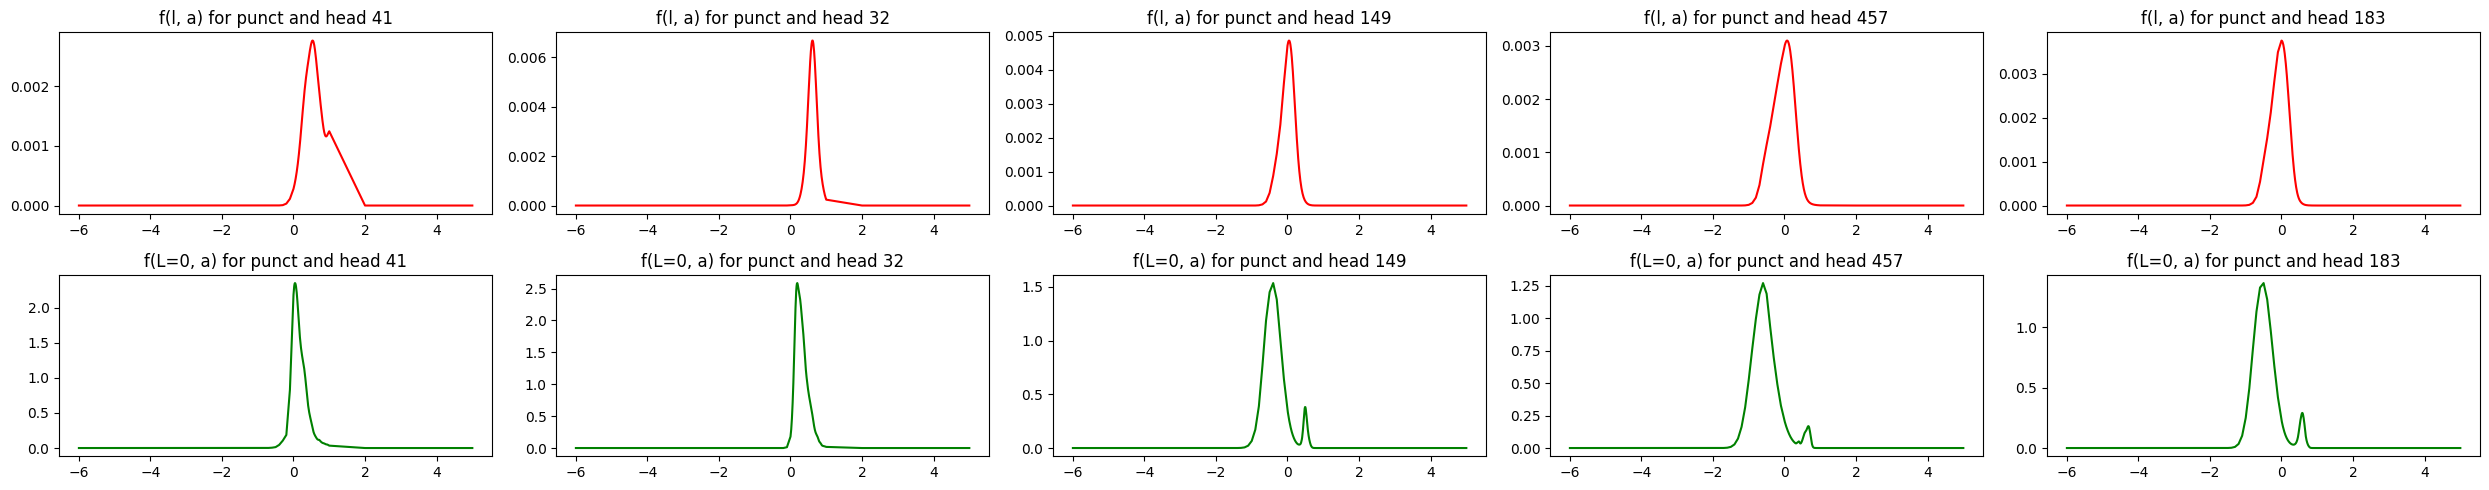

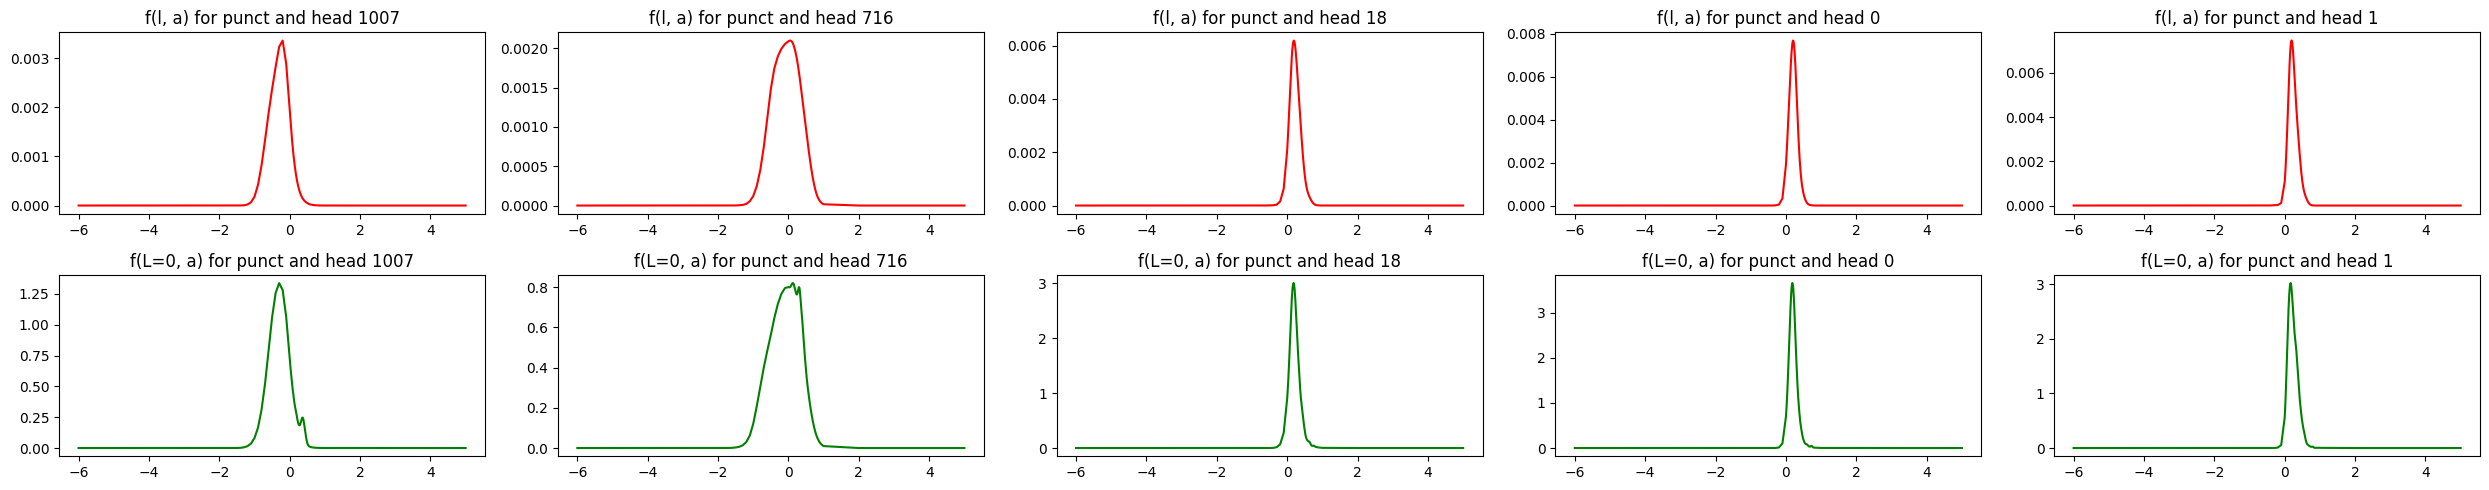

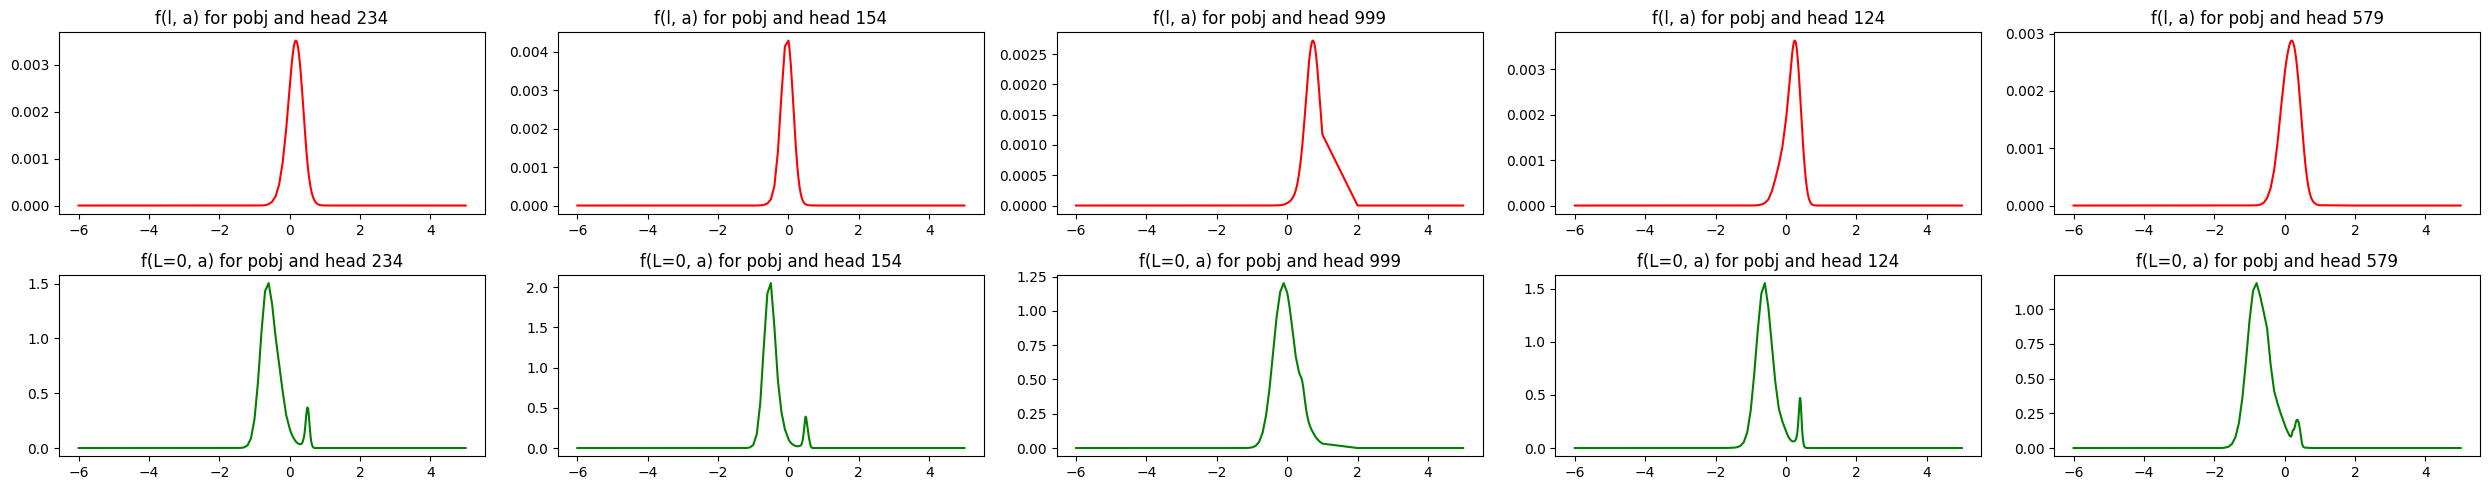

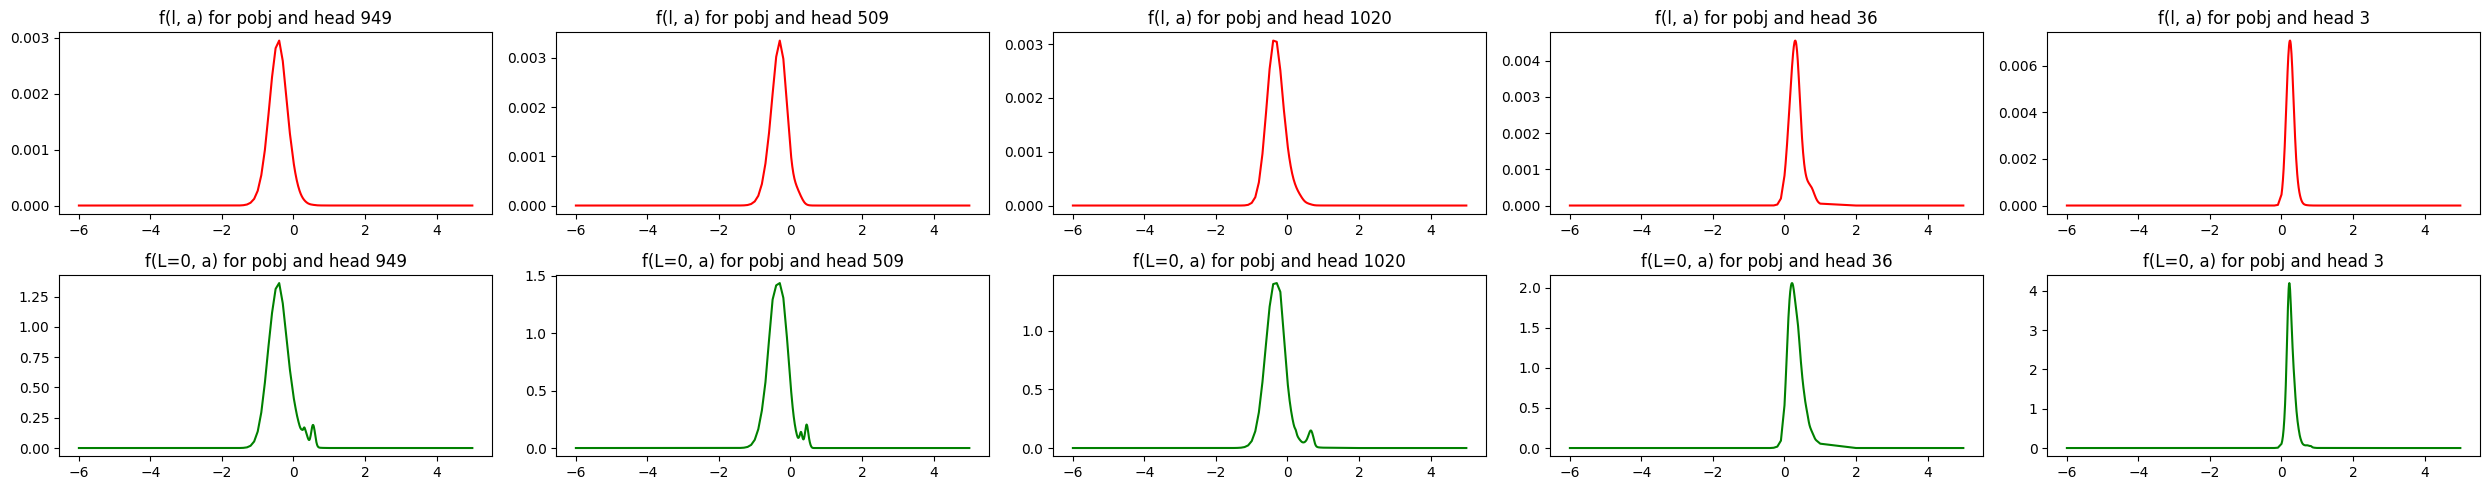

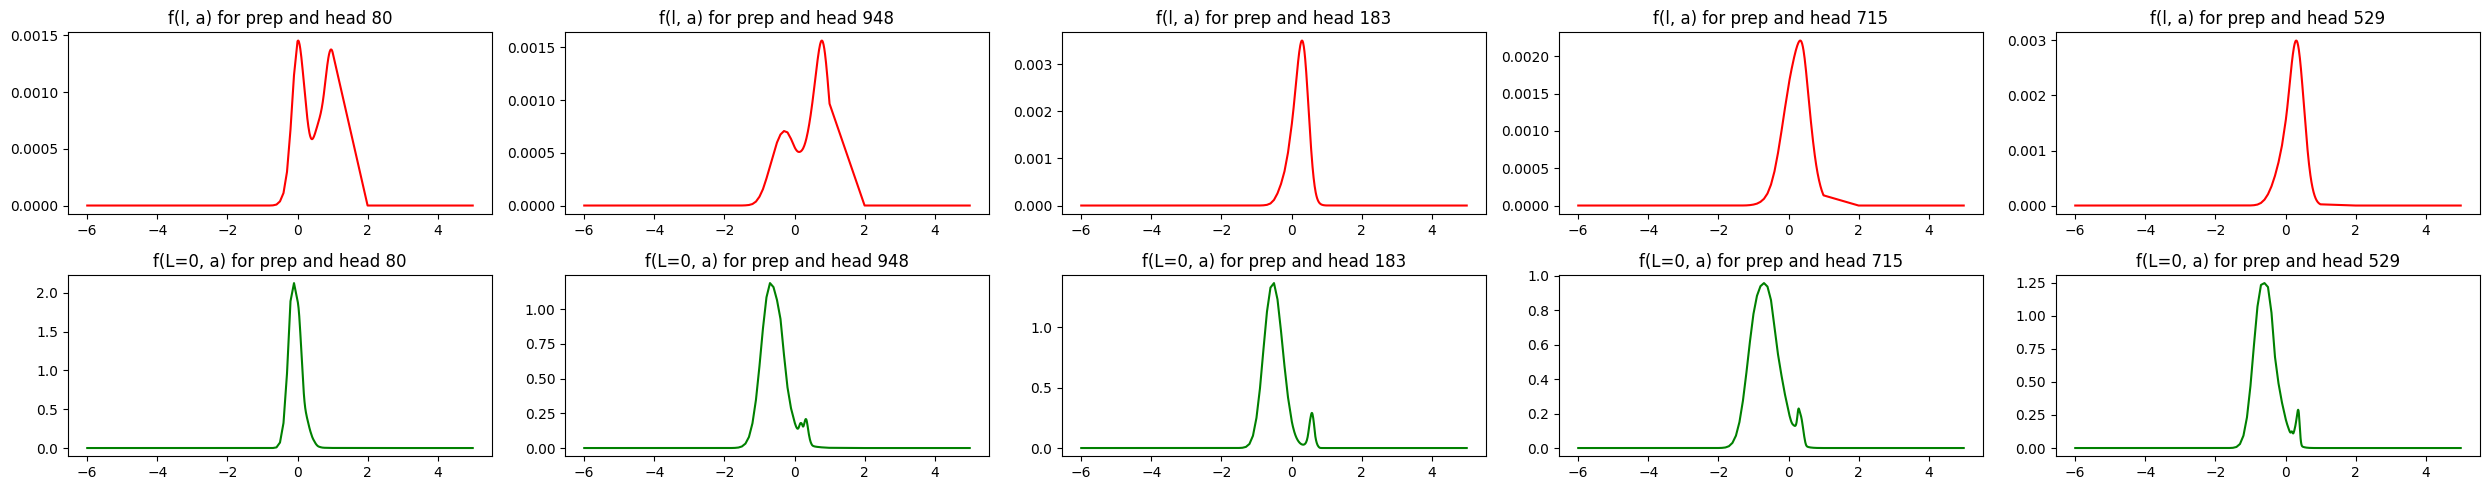

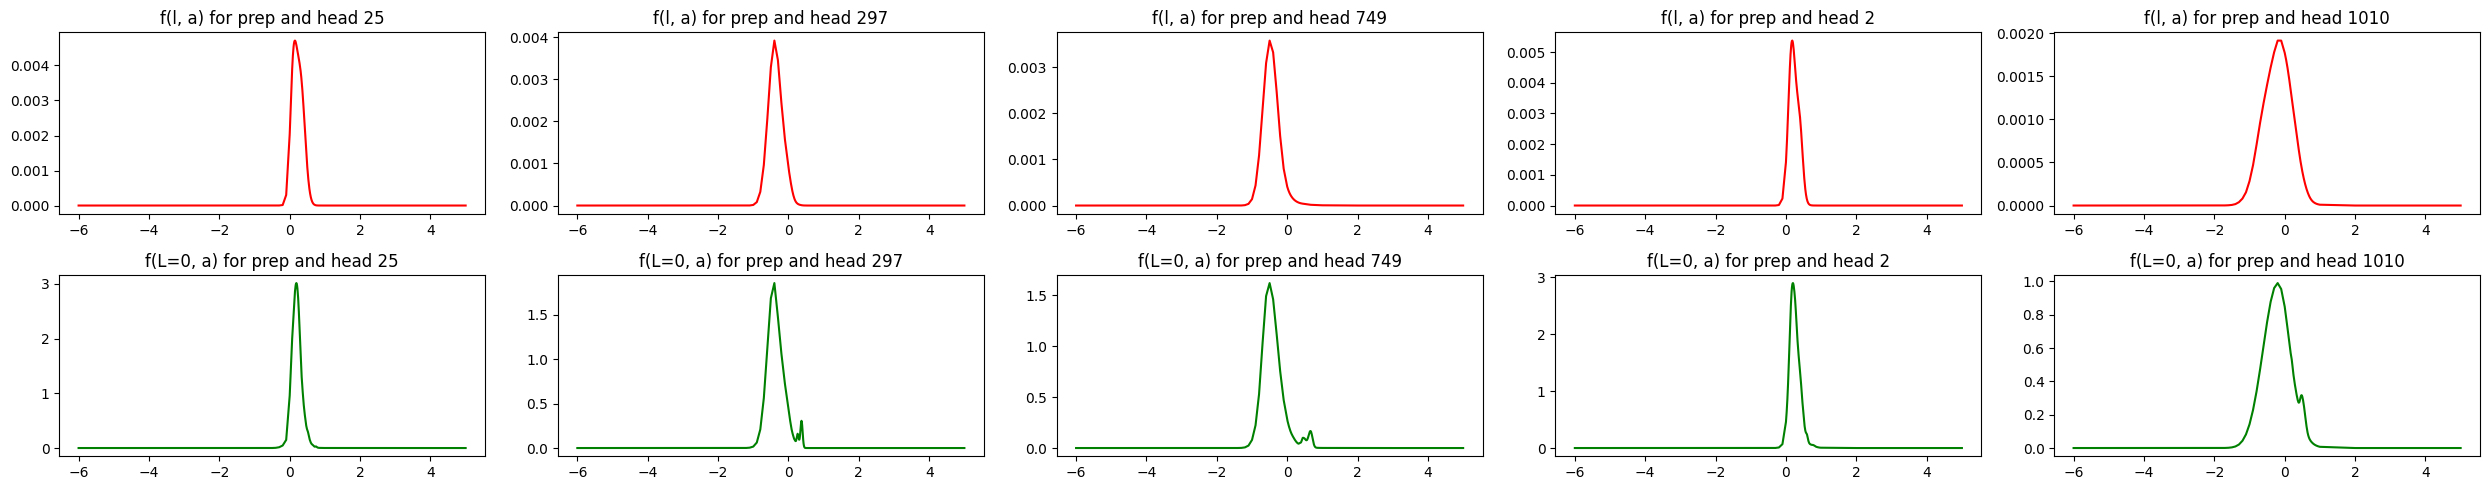

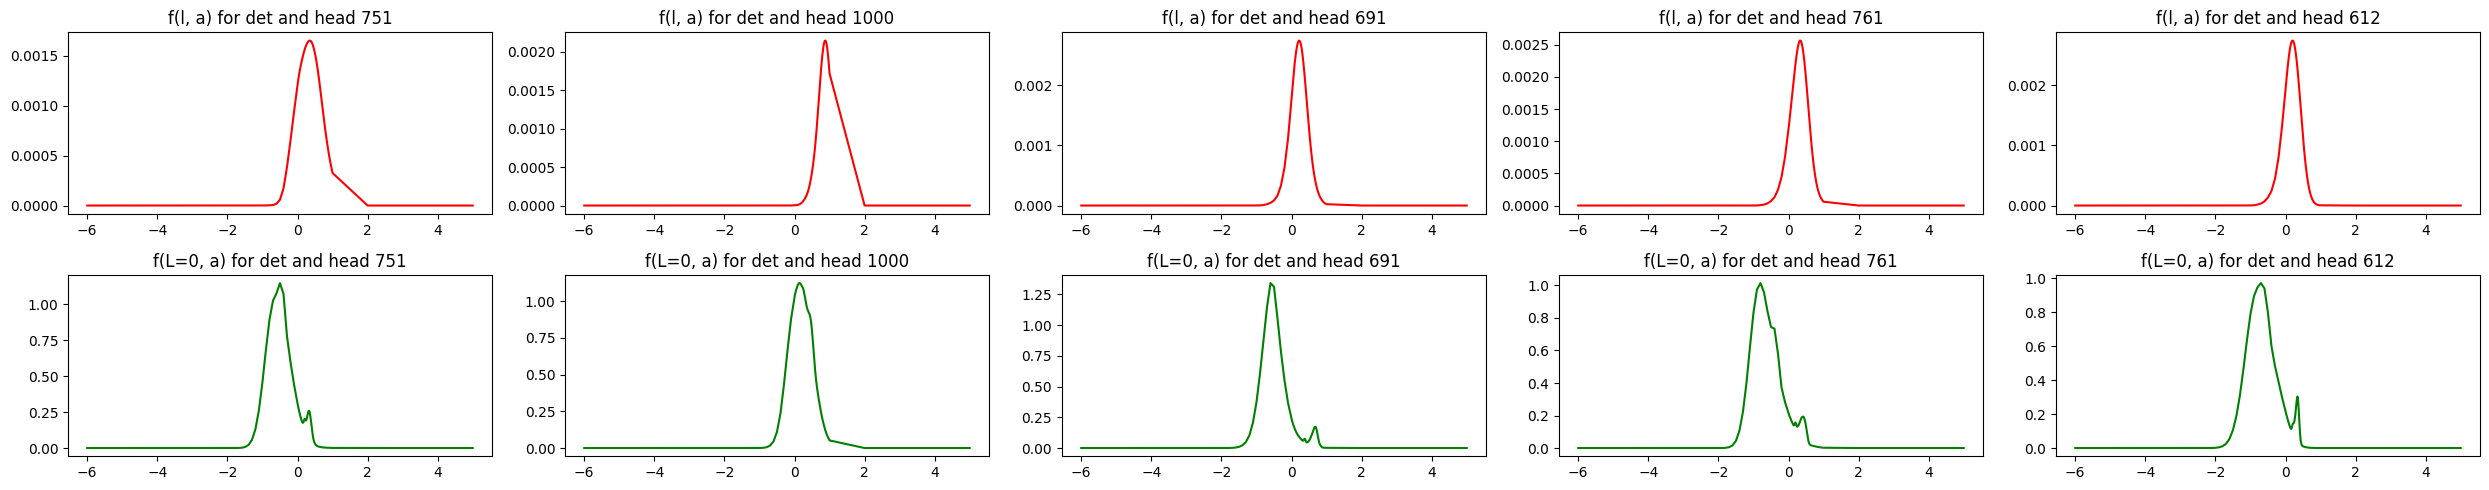

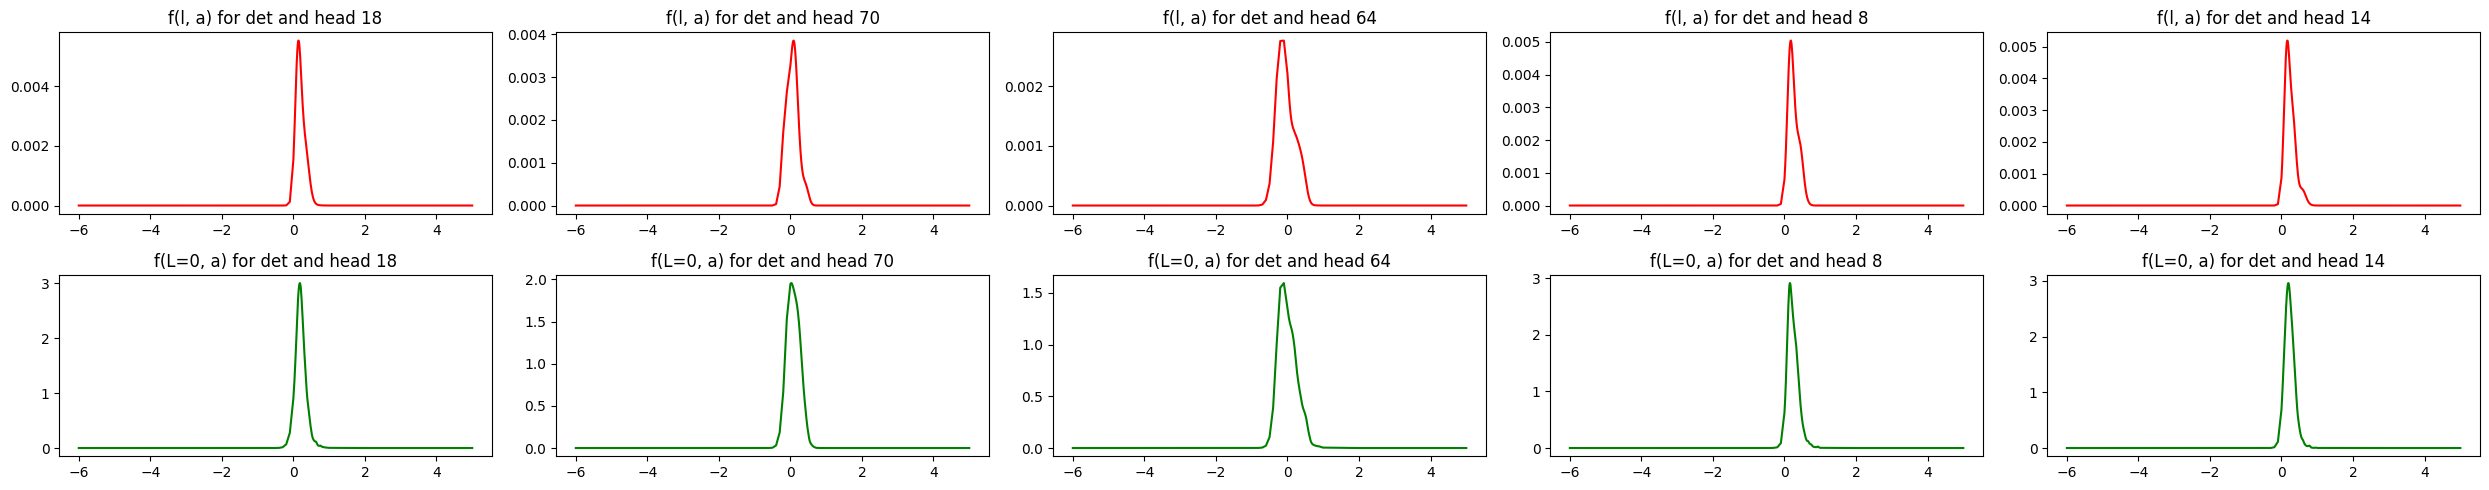

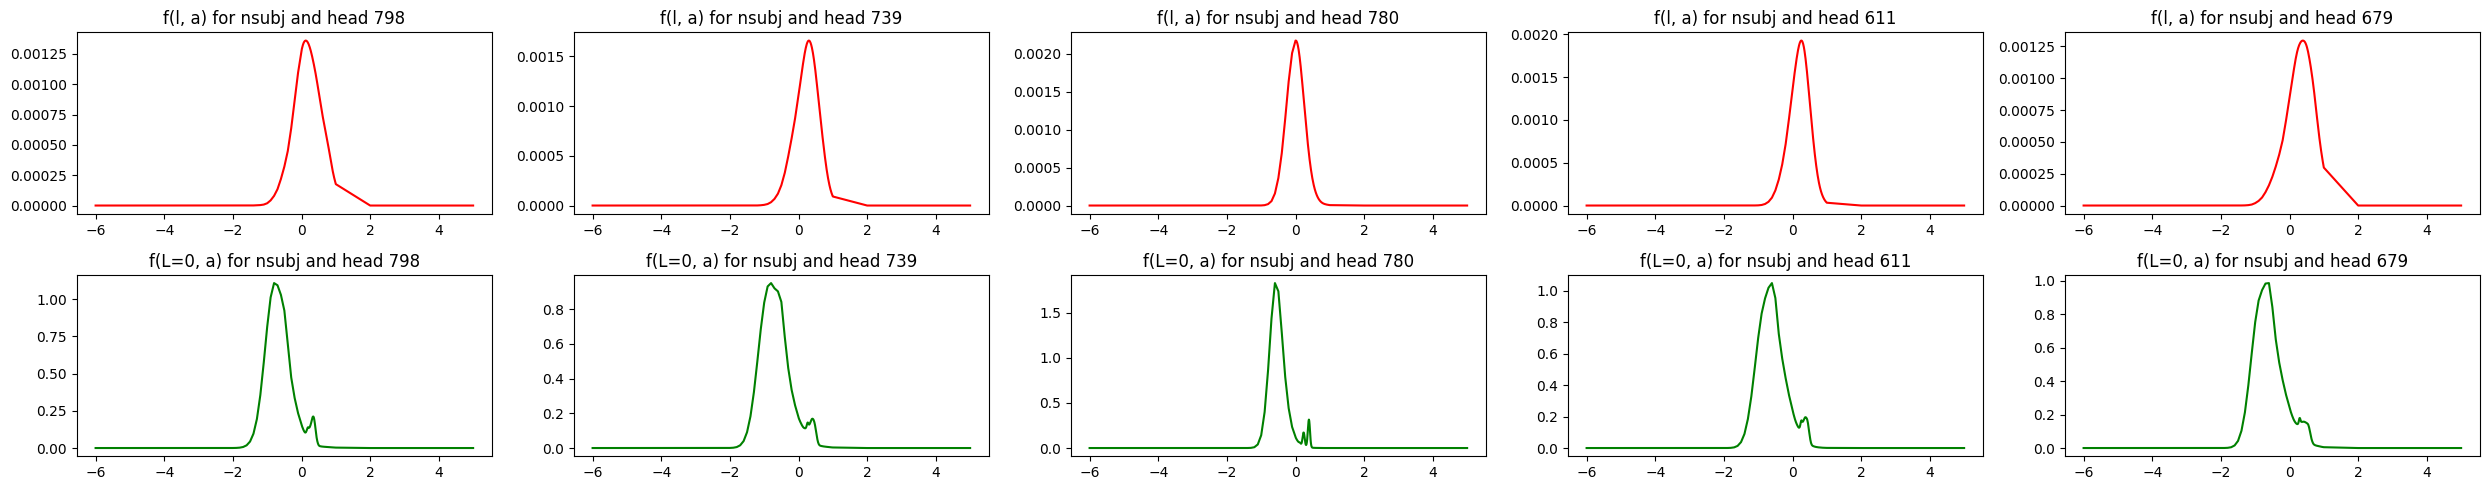

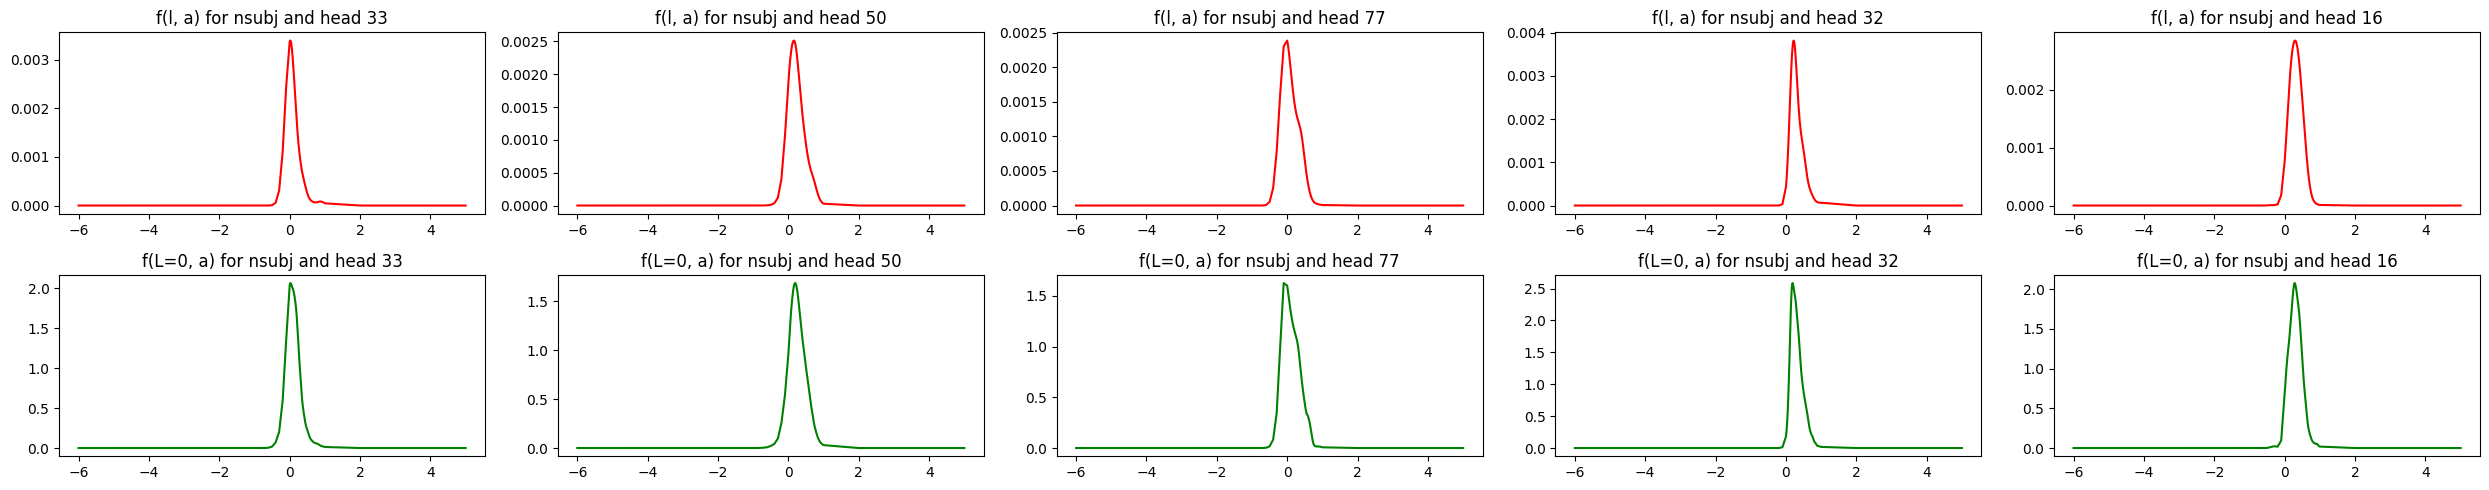

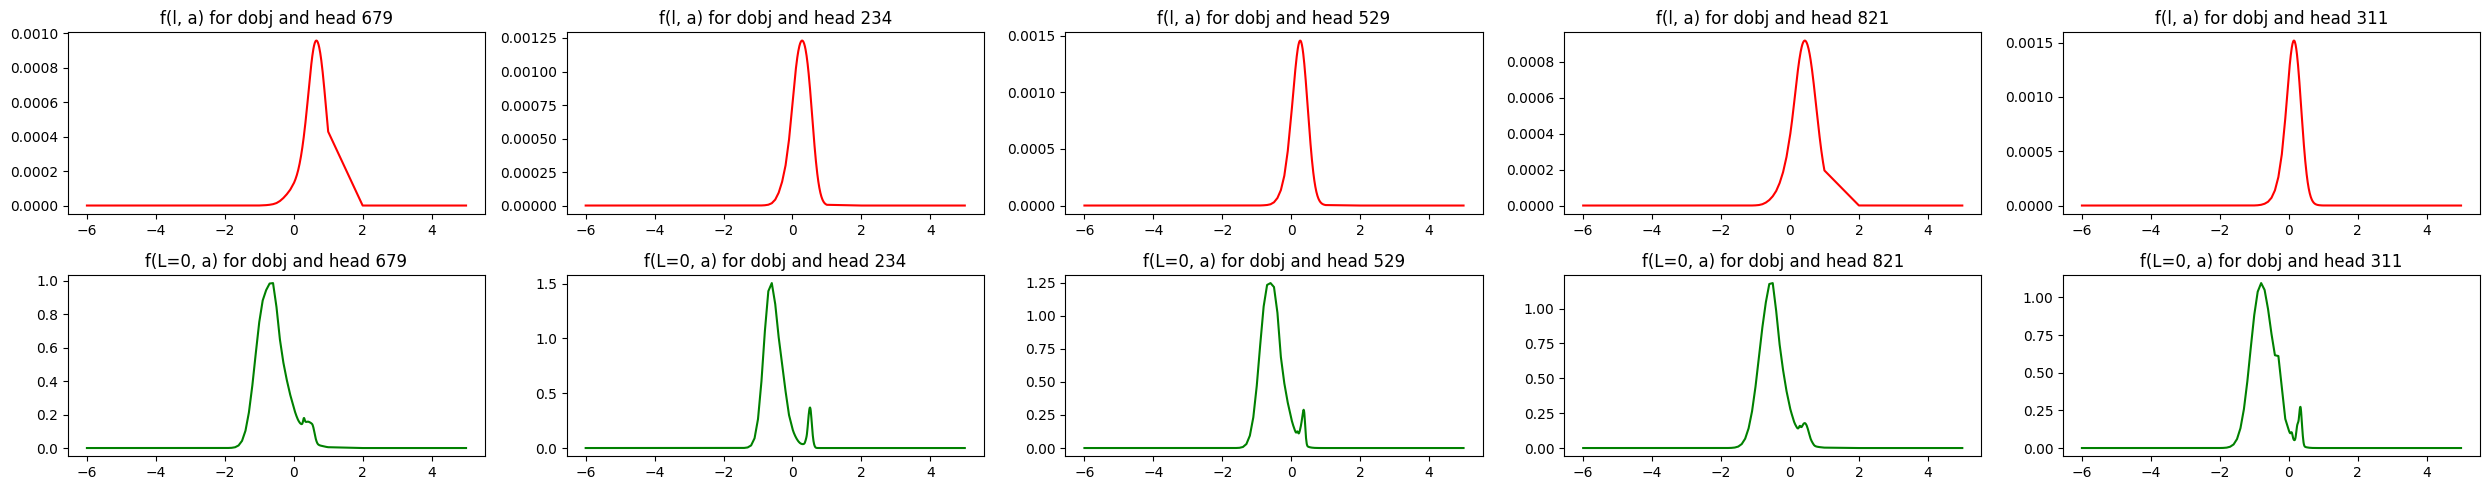

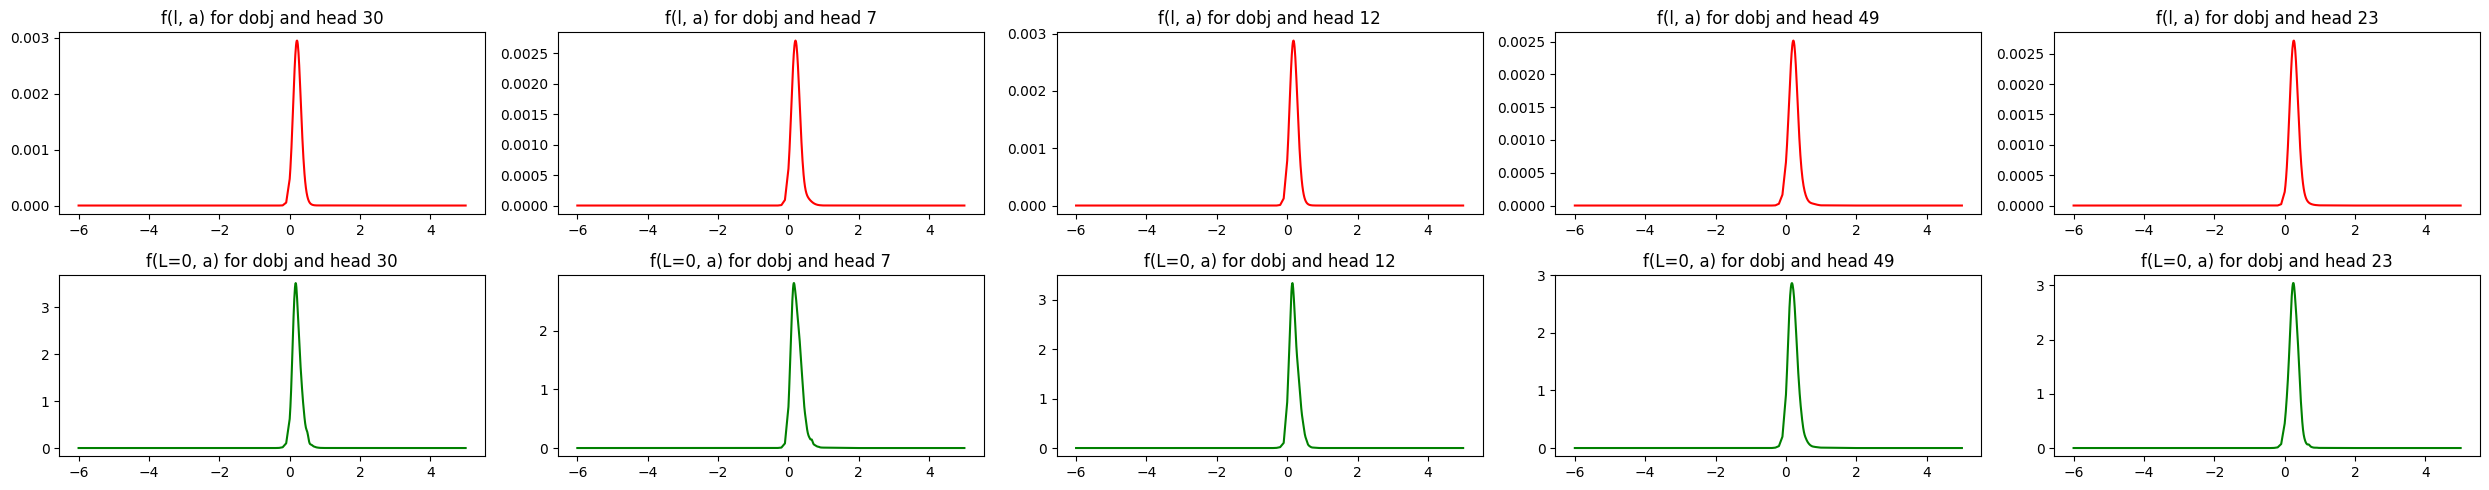

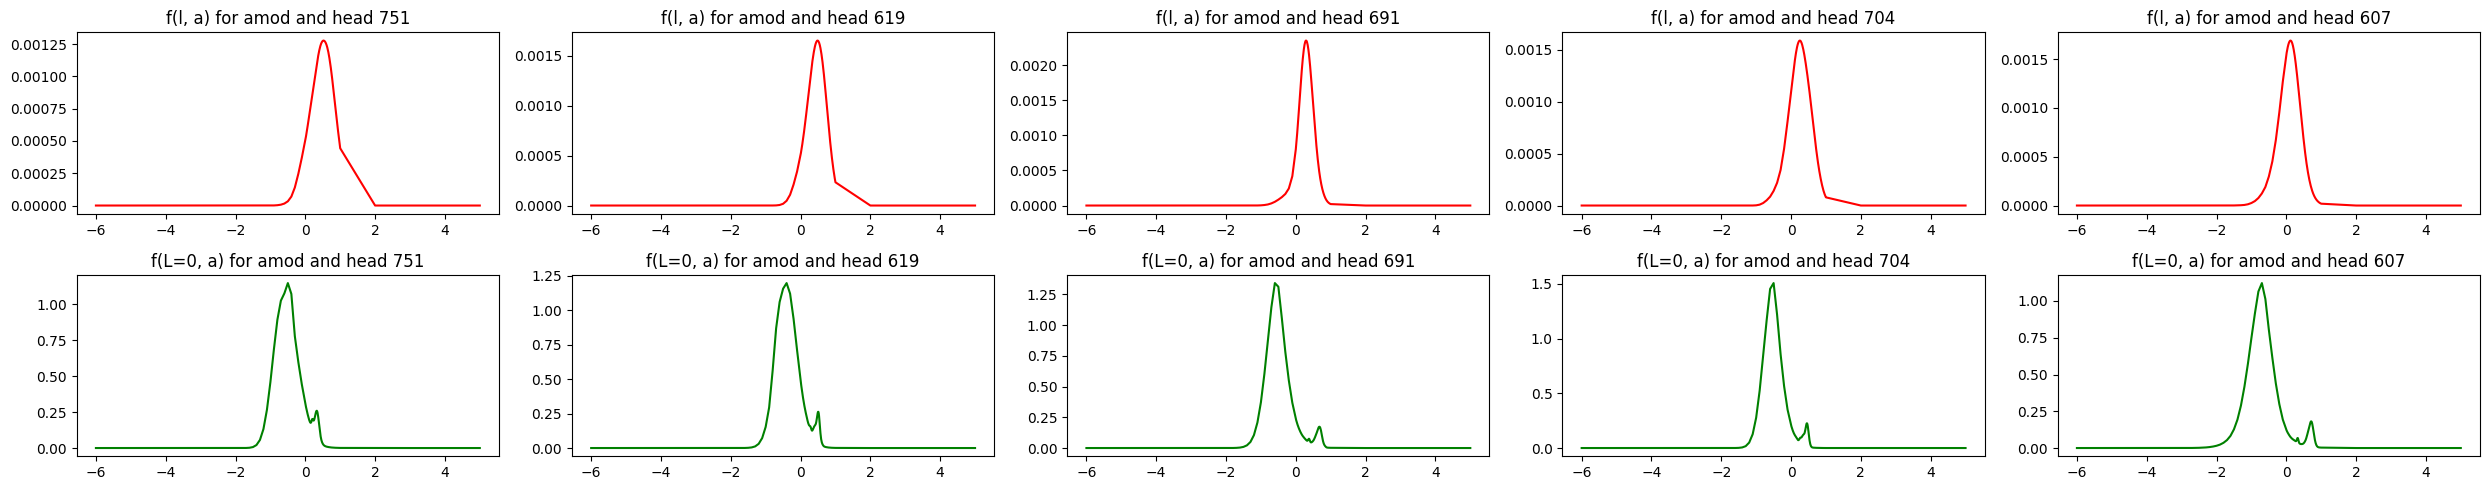

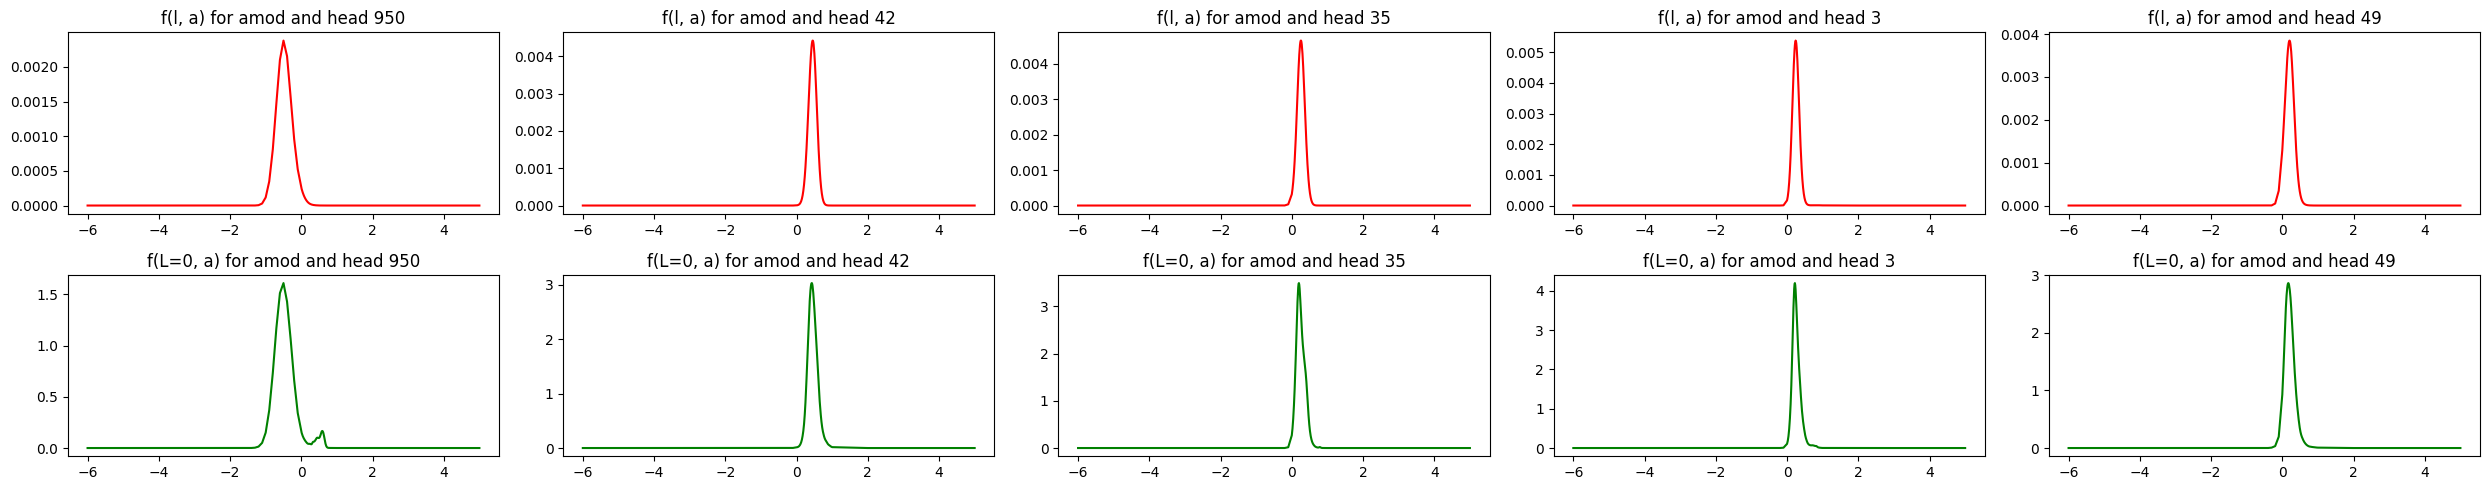

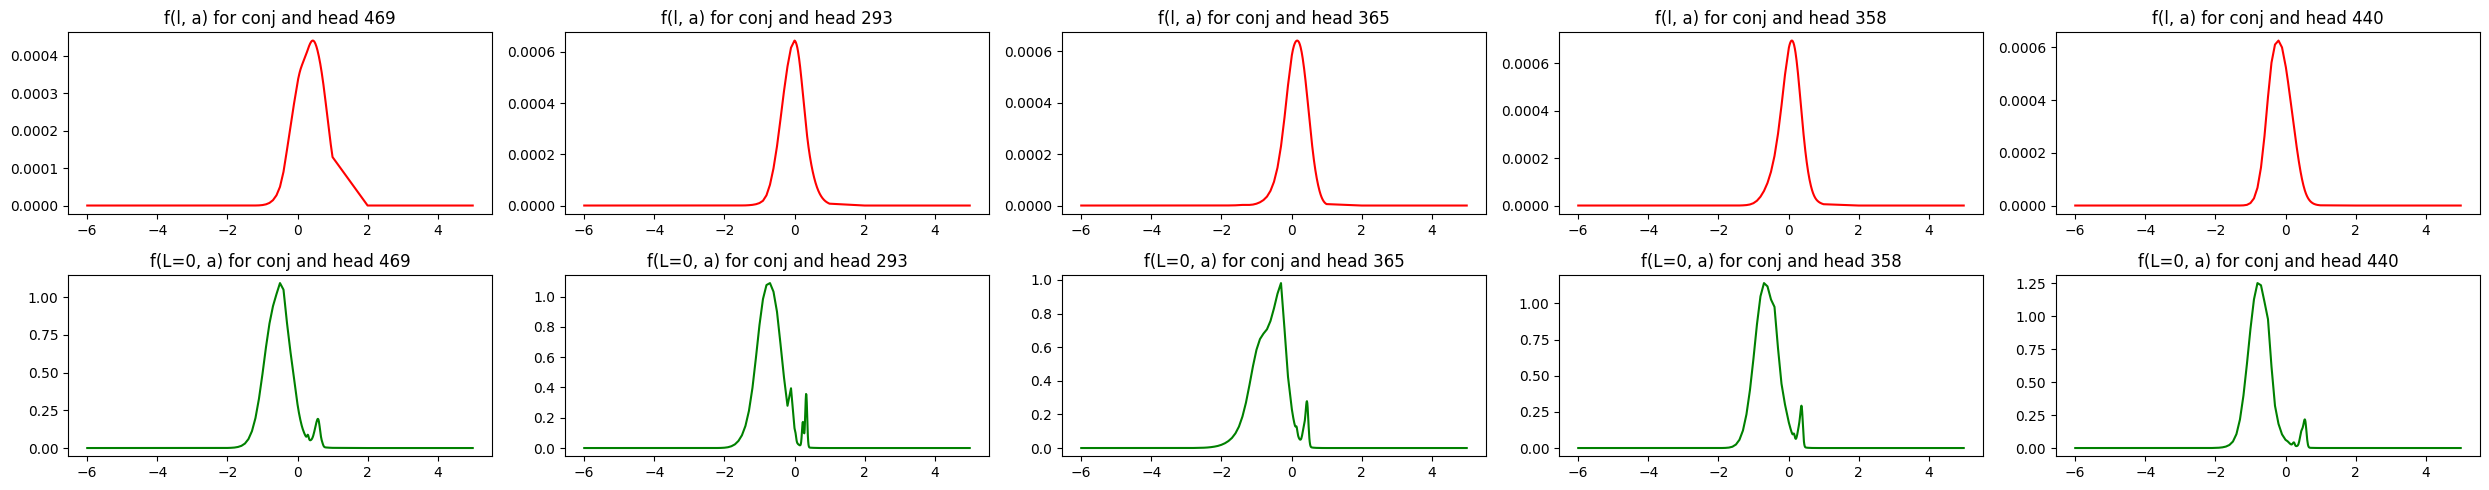

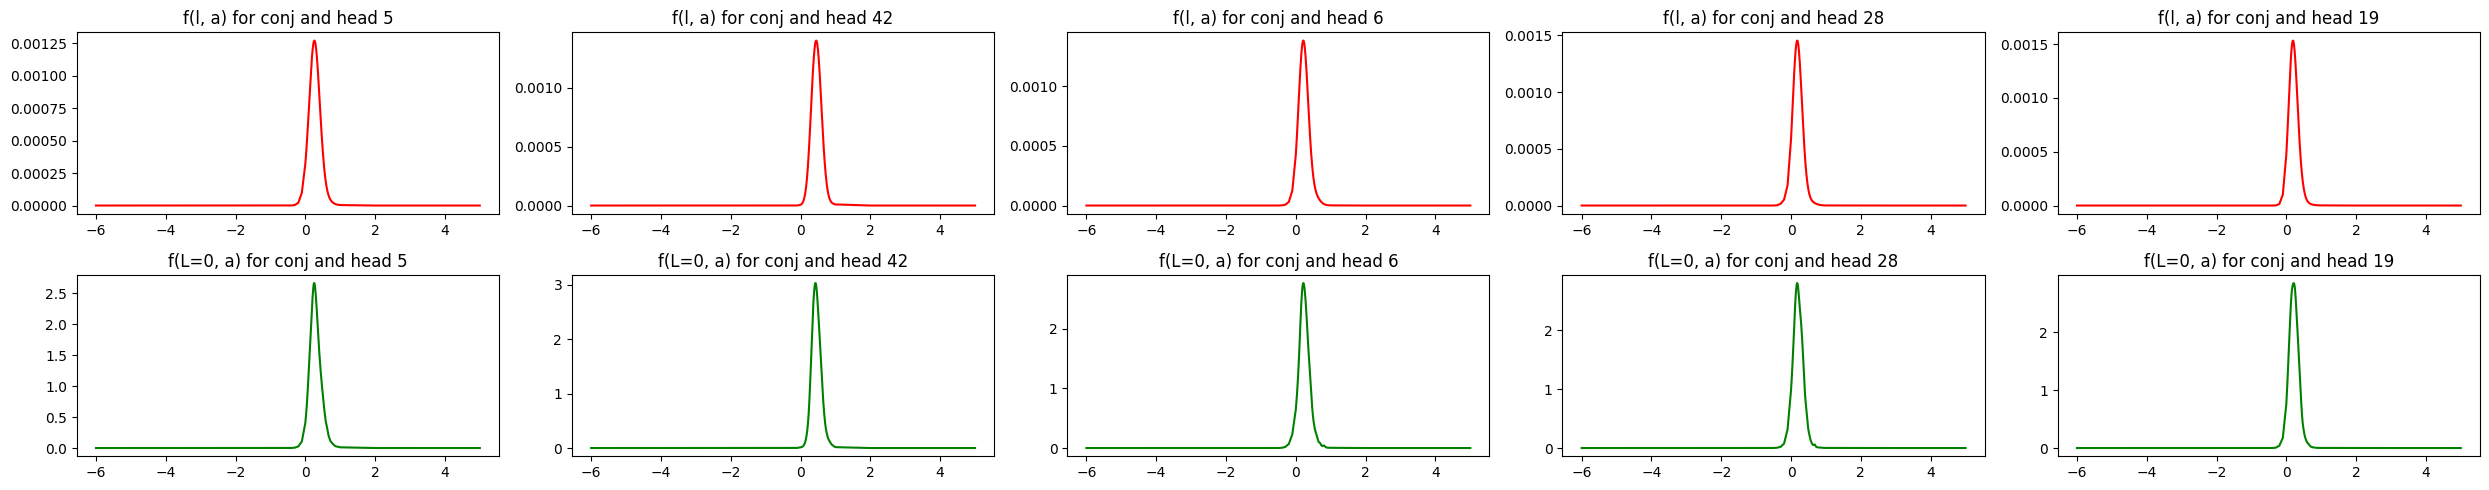

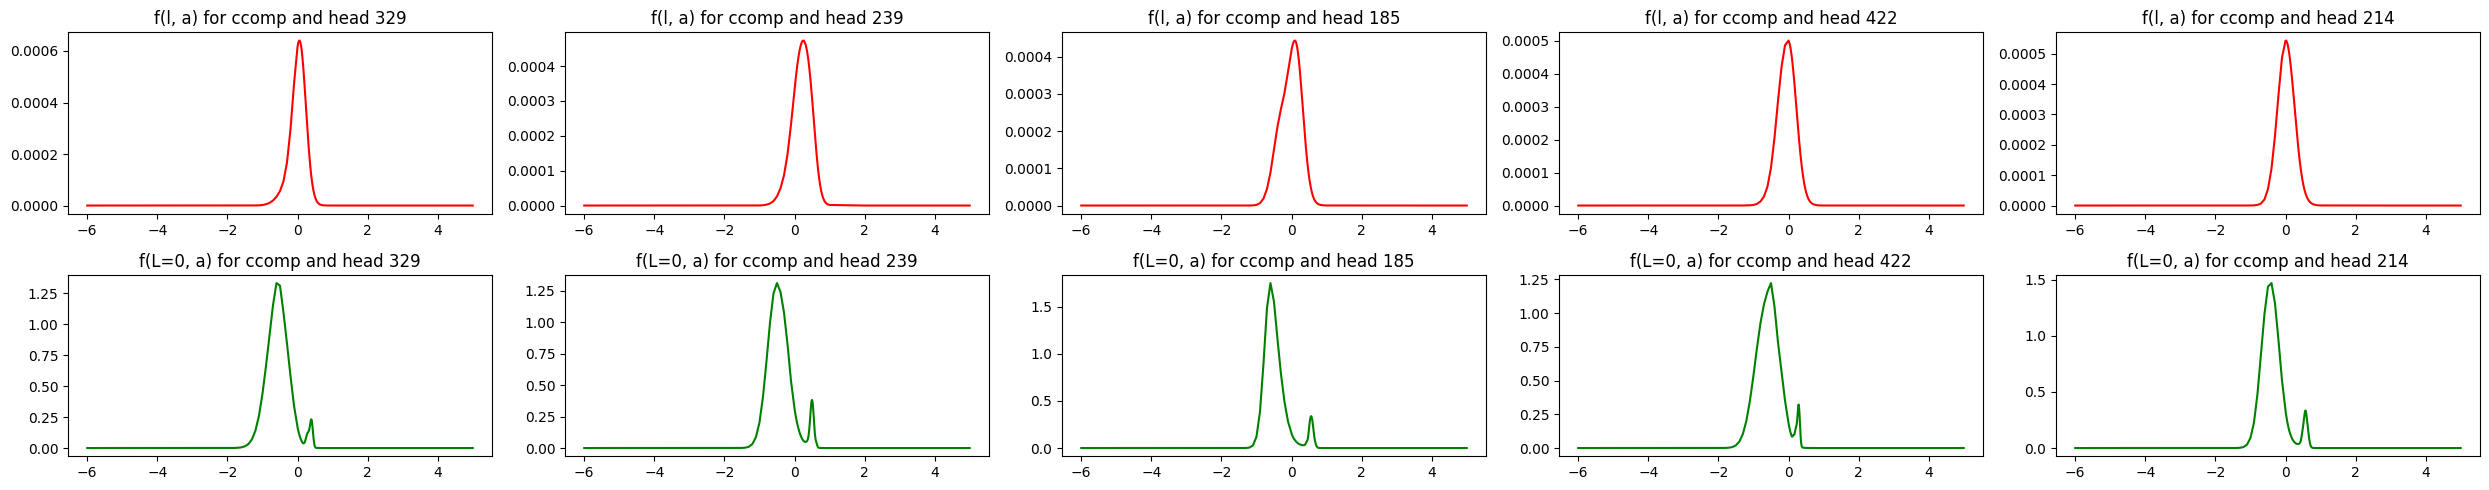

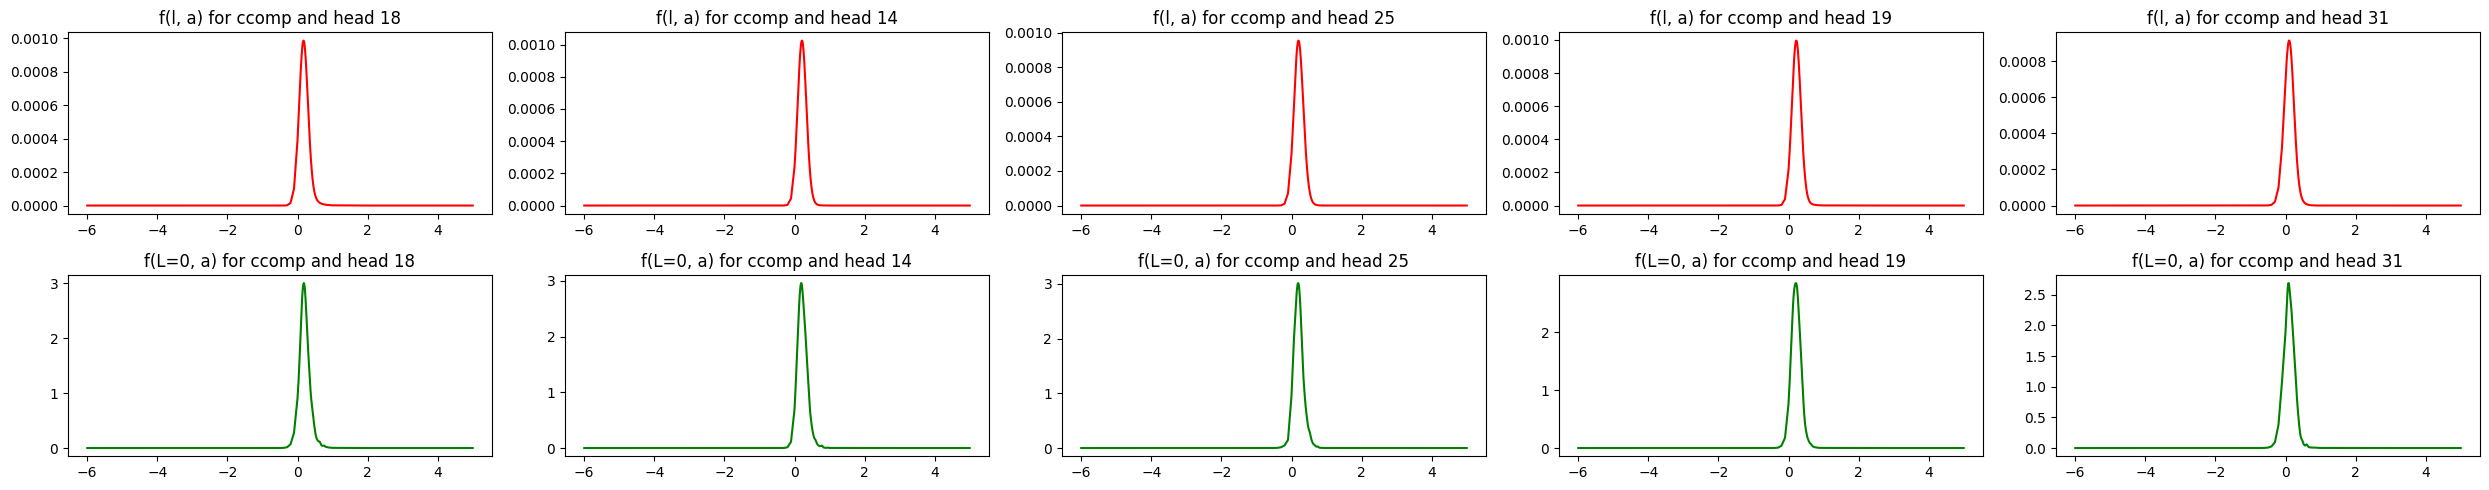

In [167]:
def visualize_topk_lastk_distributions(label_name: str, topk: int = 5, ):
    def visualize_joint_distributions(ax1: plt.Axes, ax2: plt.Axes, head_idx: int):
        # f(l,a) and f(L=0, a) with different colors
        ax1.plot(x, joint_label[head_idx][label_idx], label='f(l,a)', color='r')
        ax2.plot(x, joint_neg[head_idx], label='f(L=0,a)', color='g')
        ax1.set_title(f'f(l, a) for {label_name} and head {head_idx}')
        ax2.set_title(f'f(L=0, a) for {label_name} and head {head_idx}')

    label_idx = label_names.index(label_name)
    label_mis = mi['binary_label_mi'][label_idx]
    head_indices_sorted_by_mi = [each[0] for each in sorted(enumerate(label_mis), key=lambda x: x[1], reverse=True)]
    topk_heads, lastk_heads = head_indices_sorted_by_mi[:topk], head_indices_sorted_by_mi[-topk:]
    fig_topk, fig_lastk = plt.figure(figsize=(5 * topk, 5)), plt.figure(figsize=(5 * topk, 5))
    for head_idx in topk_heads:
        ax1 = fig_topk.add_subplot(2, topk, topk_heads.index(head_idx) + 1)
        ax2 = fig_topk.add_subplot(2, topk, topk + topk_heads.index(head_idx) + 1)
        visualize_joint_distributions(ax1, ax2, head_idx)
    
    # adjust the positions to make them tight and aligned
    fig_topk.tight_layout()
    
    for head_idx in lastk_heads:
        ax1 = fig_lastk.add_subplot(2, topk, lastk_heads.index(head_idx) + 1)
        ax2 = fig_lastk.add_subplot(2, topk, topk + lastk_heads.index(head_idx) + 1)
        visualize_joint_distributions(ax1, ax2, head_idx)

    fig_lastk.tight_layout()

labels = [each[0] for each in sorted(label_accs_filtered.items(), key=lambda x: x[1], reverse=True)[:10]]
for label_name in labels:
    visualize_topk_lastk_distributions(label_name)

[/=============================================================\
 Tokens: Bach 's         ``    Air      ''    followed .        
 Labels: poss possessive punct nsubj    punct root     punct    
 Heads:  Air  Bach       Air   followed Air   .        followed 
 Heights:2    3          2     1        2     0        1        ,
 /==============================================\
 Tokens: ``    My       fastball is   good .     
 Labels: punct poss     nsubj    cop  root punct 
 Heads:  good  fastball good     good .    good  
 Heights:1     2        1        1    0    1     ,
 /====================================================\
 Tokens: Its      maximum  velocity is  72  mph  .     
 Labels: poss     nn       nsubj    cop num root punct 
 Heads:  velocity velocity mph      mph mph .    mph   
 Heights:2        2        1        1   1   0    1     ,
 /=========================================\
 Tokens: And neither can  your  pilot .     
 Labels: cc  advmod  root poss  nsubj punct 
 Heads:

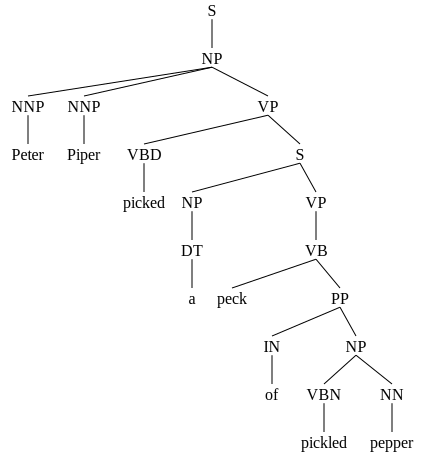

In [182]:
from nltk.tree import Tree

# Tree('S', [
#     Tree('NP', [
#         Tree('NNP', ['Peter']), Tree('NNP', ['Piper'])
#     ]), 
#     Tree('VP', [
#         Tree('VBD', ['picked']),
#         Tree('S', [
#             Tree('NP', [Tree('DT', ['a'])]),
#             Tree('VP')
#         ])
#     ]),

# ])
# Tree.fromstring('(S (NP (NNP Peter) (NNP Piper) (VP (VBD picked) (S (NP (DT a)) (VP (VB peck (PP (IN of) (NP (VBN pickled) (NN pepper)))))))))')

2025-02-14 00:41:51 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-02-14 00:41:53 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| lemma        | combined |
| constituency | wsj      |
| depparse     | combined |

2025-02-14 00:41:53 INFO: Using device: cpu
2025-02-14 00:41:53 INFO: Loading: tokenize
2025-02-14 00:41:53 INFO: Loading: pos
2025-02-14 00:41:53 INFO: Loading: lemma
2025-02-14 00:41:53 INFO: Loading: constituency
2025-02-14 00:41:53 INFO: Loading: depparse
2025-02-14 00:41:54 INFO: Done loading processors!


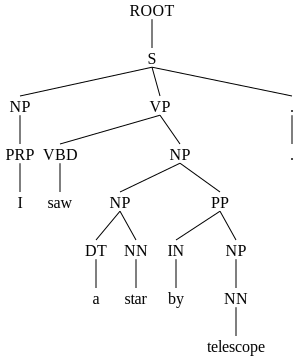

In [196]:
import stanza
from nltk import Tree
from io import StringIO

import stanza.pipeline

# Downloading https://raw.githubusercontent.com/stanfordnlp/stanza-resources/main/resources_1.5.0.json:
# 216k/? [00:00<00:00, 3.10MB/s]
# Downloading https://huggingface.co/stanfordnlp/stanza-en/resolve/v1.5.0/models/tokenize/combined.pt: 100%
# 647k/647k [00:00<00:00, 1.04MB/s]
# Downloading https://huggingface.co/stanfordnlp/stanza-en/resolve/v1.5.0/models/pos/combined.pt: 100%
# 38.5M/38.5M [00:02<00:00, 23.0MB/s]
# Downloading https://huggingface.co/stanfordnlp/stanza-en/resolve/v1.5.0/models/constituency/wsj.pt: 100%
# 113M/113M [00:06<00:00, 12.9MB/s]
# Downloading https://huggingface.co/stanfordnlp/stanza-en/resolve/v1.5.0/models/forward_charlm/1billion.pt: 100%
# 22.7M/22.7M [00:03<00:00, 9.35MB/s]
# Downloading https://huggingface.co/stanfordnlp/stanza-en/resolve/v1.5.0/models/backward_charlm/1billion.pt: 100%
# 22.7M/22.7M [00:02<00:00, 19.8MB/s]
# Downloading https://huggingface.co/stanfordnlp/stanza-en/resolve/v1.5.0/models/pretrain/combined.pt: 100%
# 107M/107M [00:05<00:00, 21.3MB/s]

# print(f'available pipelines {stanza.PIPELINE_NAMES}')
RELOAD_PIPELINE = True
if 'nlp' not in globals() or RELOAD_PIPELINE:
    nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency,lemma,depparse')
doc = nlp('I saw a star by telescope.')
tree_str = StringIO()
for sentence in doc.sentences:
    print(sentence.constituency, file=tree_str)

Tree.fromstring(tree_str.getvalue())
